In [2]:
# Import Statements

# MacOS Environment
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Standard Imports
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import re

# Machine Learning
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding, Dense, Dropout, GlobalAveragePooling1D, Input, Conv1D, MaxPooling1D, Subtract, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check Version, GPU Devices
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Tensorflow Version: 2.14.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [5]:
# Set Specific (Unused) GPU
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [6]:
# Load Datasets
dataset = 'Dataset/training.1600000.processed.noemoticon.csv'
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Read Dataset
data = pd.read_csv(dataset, encoding = 'ISO-8859-1', names = column_names)

# Displaying Head
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
# Clean Text Regex
def clean_text(text):

    # Remove Mentions, URL
    text = re.sub(r'(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ', text)

    # Remove Special Characters, Numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert To Lower Case
    text = text.lower().strip()

    # Return Cleaned Text
    return text

# Apply Cleaning Function To Text Column
data['clean_text'] = data['text'].apply(clean_text)

# Explore Target Column
target_counts = data['target'].value_counts()

# Display First Few Rows Of Cleaned Text, Target Distribution
clean_text_head = data[['clean_text', 'target']].head()
target_counts, clean_text_head

(target
 0    800000
 4    800000
 Name: count, dtype: int64,
                                           clean_text  target
 0  awww thats a bummer  you shoulda got david car...       0
 1  is upset that he cant update his facebook by t...       0
 2  i dived many times for the ball managed to sav...       0
 3     my whole body feels itchy and like its on fire       0
 4  no its not behaving at all im mad why am i her...       0)

In [8]:
# Check Text Lengths, Other Statistics
text_lengths = data['clean_text'].apply(lambda x: len(x.split()))
print(text_lengths.describe().apply(lambda x: '{:.1f}'.format(x)))
char_lengths = data['clean_text'].apply(lambda x: len(x))
print(char_lengths.describe().apply(lambda x: '{:.1f}'.format(x)))

count    1600000.0
mean          12.4
std            6.8
min            0.0
25%            7.0
50%           11.0
75%           18.0
max           40.0
Name: clean_text, dtype: object
count    1600000.0
mean          62.6
std           34.3
min            0.0
25%           34.0
50%           58.0
75%           90.0
max          179.0
Name: clean_text, dtype: object


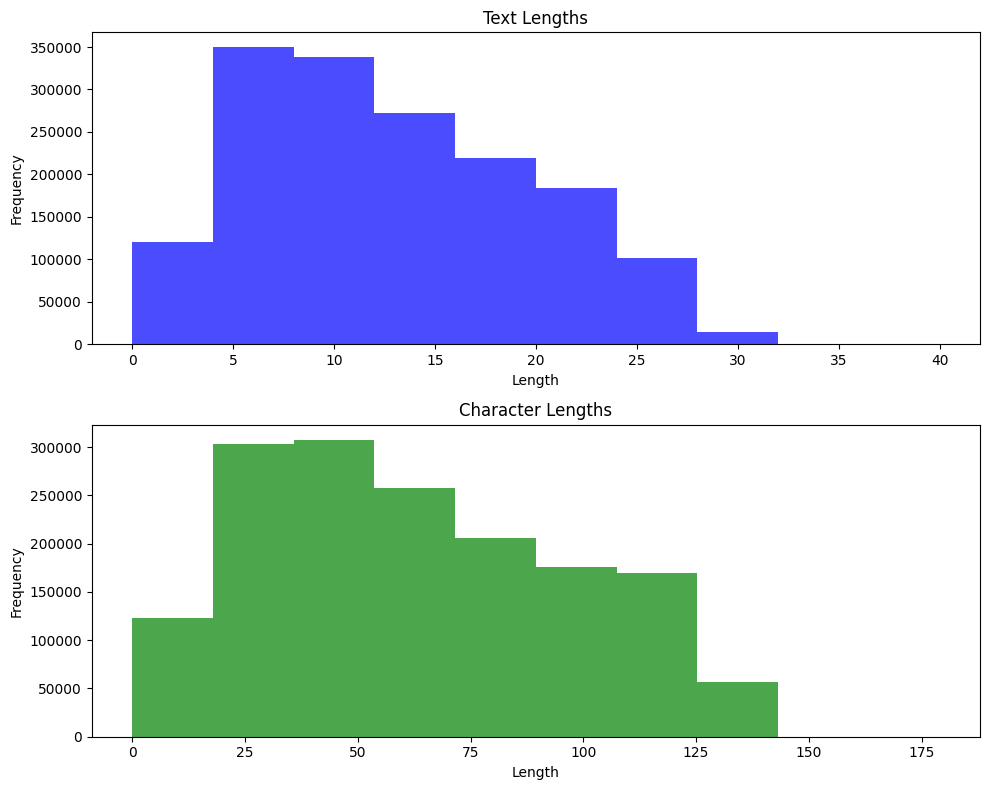

In [9]:
# Plot Histograms
fig, axs = plt.subplots(2, figsize = (10, 8))

# Plotting the histograms on separate subplots
axs[0].hist(text_lengths, color = 'blue', alpha = 0.7)
axs[0].set_title('Text Lengths')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(char_lengths, color='green', alpha = 0.7)
axs[1].set_title('Character Lengths')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')

# Displaying Plots
plt.tight_layout()
plt.show()

There's an average of 12.4 tokens in each individual Tweet, and the Tweets follow a Gamma distribution where a right-skew exists and it's unimodal. (62.6 characters per tweet on average)

In [10]:
# Encode Labels: Convert 4 -> 1 For Positive Sentiment
data['target_encoded'] = data['target'].apply(lambda x: 1 if x == 4 else 0)

# Split Data Into Features 
features = data['clean_text']
labels = data['target_encoded']

# Perform 80 / 20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# Check Shapes
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((1280000,), (320000,), (1280000,), (320000,))

In [11]:
# Setting Maximum Sequence Length
NUM_TOP_WORDS = None
MAX_ART_LEN = 180
NUM_CLASSES = 2

# Initialize, Fit Tokenizer
tokenizer = Tokenizer(num_words = NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert Text To Sequence, Padding
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(train_sequences, maxlen = MAX_ART_LEN)
X_test = pad_sequences(test_sequences, maxlen = MAX_ART_LEN)

# Ensure Types Are Float32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [12]:
# Preparing GloVe Embedding
glove_file = 'Dataset/glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file, 'r', encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs

# Print Word Vector Information
print('Found %s Word Vectors.' % len(embeddings_index))

# Create Embedding Matrix
found_words = 0
EMBED_SIZE = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

# Print Embedding Information
print("Embedding Shape:", embedding_matrix.shape,
      "\nTotal Words Found:", found_words,
      "\nPercentage:", 100 * found_words / embedding_matrix.shape[0])

# Check Shapes Of Padded Train Test Data
X_train.shape, X_test.shape, embedding_matrix.shape

Found 400000 Word Vectors.
Embedding Shape: (361091, 100) 
Total Words Found: 87363 
Percentage: 24.194178198847382


((1280000, 180), (320000, 180), (361091, 100))

In [15]:
# Function To Plot ROC, Calculate AUC
def plot_roc_curve(y_test, y_pred, title):

    # Already Binarized
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC Curve (Area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC For ' + title)
    plt.legend(loc = "lower right")
    plt.show()

In [16]:
# Save Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights = [embedding_matrix],
                            input_length = MAX_ART_LEN,
                            trainable = False)

### **2.1: Basic 1D CNN W/ Standard Parameters**

In [17]:
# Sequence Input
sequence_input = Input(shape = (MAX_ART_LEN,), dtype = 'int32')

# Embedding
embedded_sequences = embedding_layer(sequence_input)

# Convolve Embedded Sequence 
x = Conv1D(64, 5, activation = 'relu', kernel_initializer = 'he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

# Extract Additional Features
x = Conv1D(64, 5, activation = 'relu', kernel_initializer = 'he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation = 'relu', kernel_initializer = 'he_uniform')(x)
x = Dropout(0.2)(x)

# Take Mean Across Resulting Features (Global Flatten)
x_mean = GlobalAveragePooling1D()(x)

# Take Variance Of Elements Across Features
x_tmp = Subtract()([x, x_mean])
x_std = GlobalAveragePooling1D()(x_tmp ** 2)
x = Concatenate(name = 'concat_1')([x_mean, x_std])
x = Dense(64, activation = 'relu', kernel_initializer = 'he_uniform')(x)
x = Dropout(0.2)(x)

# Get Predictions
preds = Dense(1, activation = 'sigmoid', kernel_initializer = 'glorot_uniform')(x)
cnn1 = Model(sequence_input, preds)
print(cnn1.summary())

2023-12-10 20:33:00.244394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 73094 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 180, 100)             3610910   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 176, 64)              32064     ['embedding_1[0][0]']         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 35, 64)               0         ['conv1d[0][0]']          

In [18]:
# Exponential Decay Scheduler For Adam Optimizer
lr_schedule = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 10000,
    decay_rate = 0.95,
    staircase = True) 
opt = Adam(epsilon = 0.0001, learning_rate = lr_schedule)
cnn1.compile(loss = 'binary_crossentropy',
             optimizer = opt,
             metrics = ['accuracy', Precision(), Recall(), F1Score()])

In [21]:
# Running 1D CNN Model
history_cnn1 = []
tmp = cnn1.fit(X_train, y_train, epochs = 20,
                batch_size = 512, 
                validation_data = (X_test, y_test))
history_cnn1.append(tmp)

Epoch 1/20
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6318 - accuracy: 0.6343 - precision: 0.6101 - recall: 0.7424 - f1_score: 0.6663 - val_loss: 0.6207 - val_accuracy: 0.6425 - val_precision: 0.6021 - val_recall: 0.8466 - val_f1_score: 0.6681
Epoch 2/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6151 - accuracy: 0.6504 - precision: 0.6219 - recall: 0.7654 - f1_score: 0.6663 - val_loss: 0.6092 - val_accuracy: 0.6553 - val_precision: 0.6286 - val_recall: 0.7644 - val_f1_score: 0.6681
Epoch 3/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6095 - accuracy: 0.6555 - precision: 0.6256 - recall: 0.7730 - f1_score: 0.6663 - val_loss: 0.6061 - val_accuracy: 0.6572 - val_precision: 0.6354 - val_recall: 0.7428 - val_f1_score: 0.6681
Epoch 4/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6059 - accuracy: 0.6583 - precision: 0.6279 - recall: 0.7762 - f1_score: 0.6663 - val_loss: 0.6049 - val_accuracy:

In [22]:
tmp = cnn1.fit(X_train, y_train, epochs = 20,
                batch_size = 512, 
                validation_data = (X_test, y_test))
history_cnn1.append(tmp)

Epoch 1/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5885 - accuracy: 0.6731 - precision: 0.6405 - recall: 0.7881 - f1_score: 0.6663 - val_loss: 0.5977 - val_accuracy: 0.6651 - val_precision: 0.6331 - val_recall: 0.7904 - val_f1_score: 0.6681
Epoch 2/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5881 - accuracy: 0.6734 - precision: 0.6404 - recall: 0.7898 - f1_score: 0.6663 - val_loss: 0.5971 - val_accuracy: 0.6654 - val_precision: 0.6307 - val_recall: 0.8031 - val_f1_score: 0.6681
Epoch 3/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5878 - accuracy: 0.6735 - precision: 0.6403 - recall: 0.7905 - f1_score: 0.6663 - val_loss: 0.5973 - val_accuracy: 0.6659 - val_precision: 0.6331 - val_recall: 0.7938 - val_f1_score: 0.6681
Epoch 4/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5874 - accuracy: 0.6742 - precision: 0.6410 - recall: 0.7906 - f1_score: 0.6663 - val_loss: 0.5987 - val_accuracy:

It sucks as expected cant even get 70% :sob: :sob:

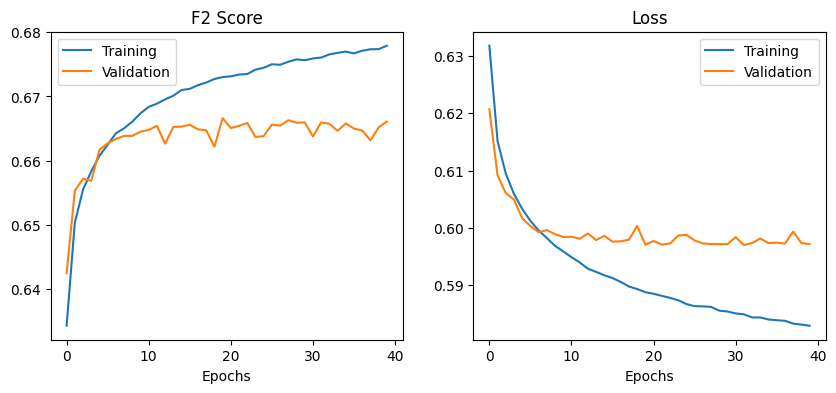

10000/10000 [==============================] - 10s 955us/step


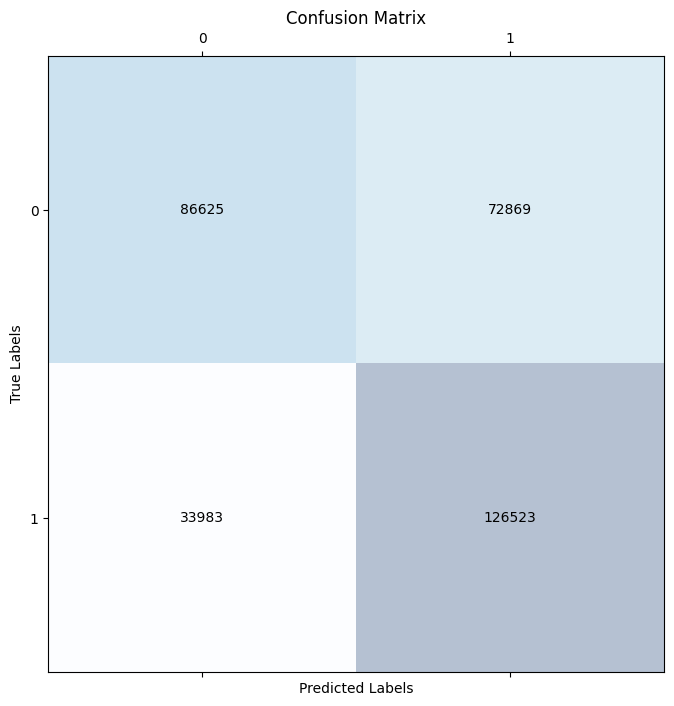

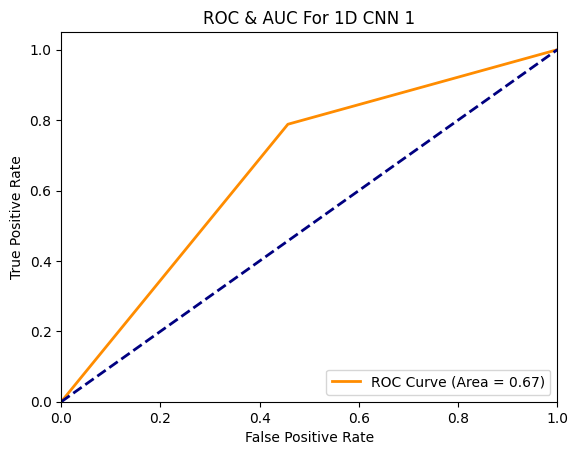

Validation Scores:
	F1 Score: 0.6680707931518555
	Recall: 0.7882758378982544
	Precision: 0.6345440149307251
	Accuracy: 0.6660875082015991


In [24]:
# Combine All Histories Together
combined = dict()
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'val_precision', 'val_recall', 'val_f1_score']:
    combined[key] = np.hstack([x.history[key] for x in history_cnn1])

# Plot Training, Val Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(combined['accuracy'], label = 'Training')
plt.plot(combined['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('F2 Score')
plt.legend()

# Plot Training, Val Loss
plt.subplot(1, 2, 2)
plt.plot(combined['loss'], label = 'Training')
plt.plot(combined['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After Training, Predict Classes
y_pred = cnn1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC, Calculate AUC
plot_roc_curve(y_test, y_pred_classes, '1D CNN 1')
print(f"Validation Scores:\n\tF1 Score: {combined['val_f1_score'][-1][-1]}\n\tRecall: {combined['val_recall'][-1]}")
print(f"\tPrecision: {combined['val_precision'][-1]}\n\tAccuracy: {combined['val_accuracy'][-1]}")

Confusion Matrix looks correct! We aren't exactly converged but this model is not getting better in terms of validation accuracy. The ROC is ugly asf unfortunately... It's time to move on :sob:

### **2.2: Retrain 1D CNN W/ Changed Adam Optimizer**

Last big boi was barely training. That's an uh oh if I've ever seen one. Let's try another optimizer and see if our problem may have been related to the slowness of the optimizer across the loss landscape.

In [ ]:
# Trying RMSProp Optimizer
cnn2 = Model(sequence_input, preds)
cnn2.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy', Precision(), Recall(), F1Score()])

In [46]:
# Same As Before
history_cnn2 = []
tmp = cnn2.fit(X_train, y_train, epochs = 20, 
                batch_size = 512, 
                validation_data = (X_test, y_test))
history_cnn2.append(tmp)

Epoch 1/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5961 - accuracy: 0.6668 - precision_8: 0.6414 - recall_8: 0.7554 - f1_score: 0.6663 - val_loss: 0.6003 - val_accuracy: 0.6655 - val_precision_8: 0.6357 - val_recall_8: 0.7806 - val_f1_score: 0.6681
Epoch 2/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5962 - accuracy: 0.6673 - precision_8: 0.6426 - recall_8: 0.7530 - f1_score: 0.6663 - val_loss: 0.6002 - val_accuracy: 0.6654 - val_precision_8: 0.6355 - val_recall_8: 0.7810 - val_f1_score: 0.6681
Epoch 3/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5954 - accuracy: 0.6669 - precision_8: 0.6421 - recall_8: 0.7533 - f1_score: 0.6663 - val_loss: 0.6006 - val_accuracy: 0.6652 - val_precision_8: 0.6326 - val_recall_8: 0.7931 - val_f1_score: 0.6681
Epoch 4/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5952 - accuracy: 0.6671 - precision_8: 0.6427 - recall_8: 0.7513 - f1_score: 0.6663 - val_loss

In [47]:
tmp = cnn2.fit(X_train, y_train, epochs = 20,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_cnn2.append(tmp)

Epoch 1/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5920 - accuracy: 0.6695 - precision_8: 0.6443 - recall_8: 0.7559 - f1_score: 0.6663 - val_loss: 0.5995 - val_accuracy: 0.6650 - val_precision_8: 0.6348 - val_recall_8: 0.7821 - val_f1_score: 0.6681
Epoch 2/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5918 - accuracy: 0.6696 - precision_8: 0.6440 - recall_8: 0.7573 - f1_score: 0.6663 - val_loss: 0.5995 - val_accuracy: 0.6650 - val_precision_8: 0.6335 - val_recall_8: 0.7882 - val_f1_score: 0.6681
Epoch 3/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5916 - accuracy: 0.6697 - precision_8: 0.6442 - recall_8: 0.7571 - f1_score: 0.6663 - val_loss: 0.5990 - val_accuracy: 0.6655 - val_precision_8: 0.6358 - val_recall_8: 0.7798 - val_f1_score: 0.6681
Epoch 4/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5918 - accuracy: 0.6702 - precision_8: 0.6445 - recall_8: 0.7577 - f1_score: 0.6663 - val_loss

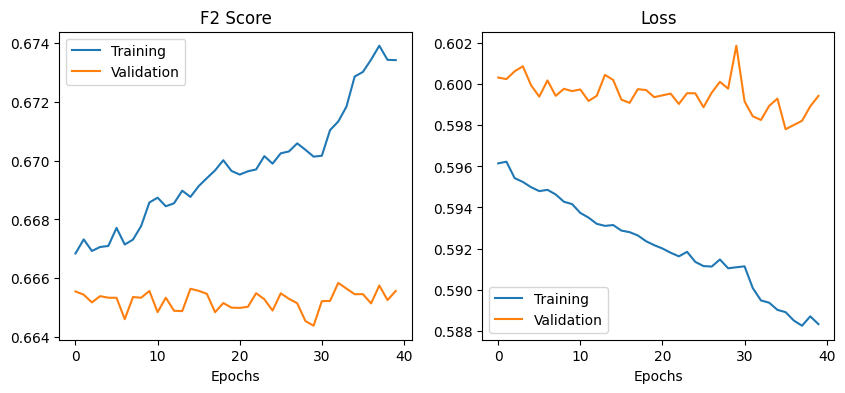

10000/10000 [==============================] - 10s 959us/step


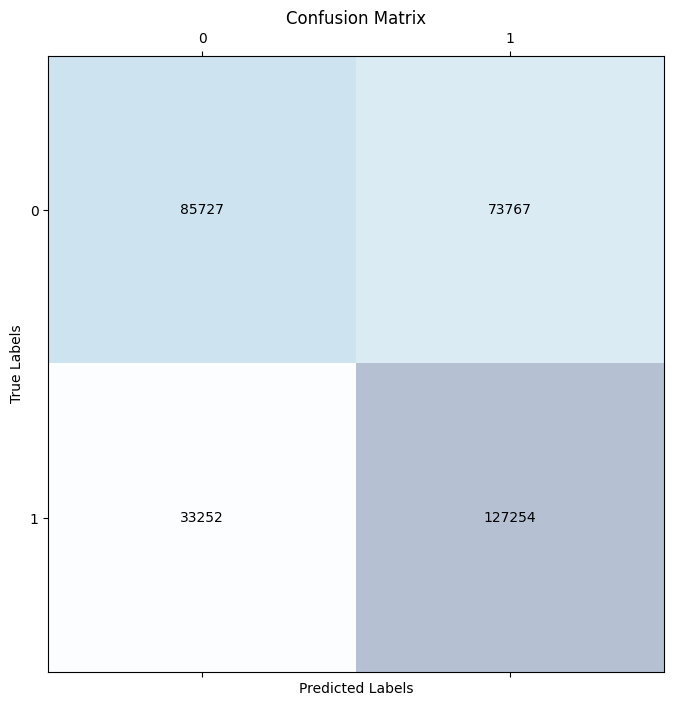

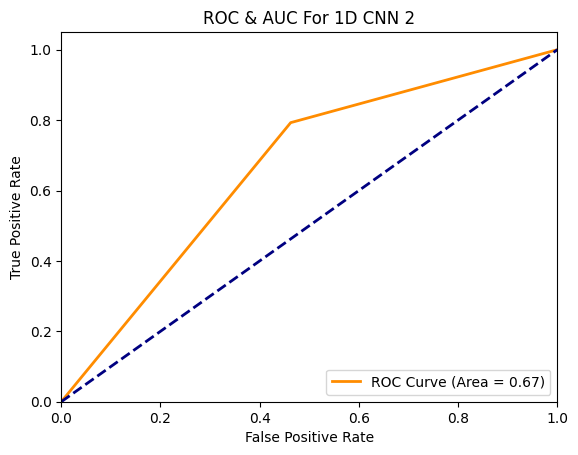

Validation Scores:
	F1 Score: 0.6680707931518555
	Recall: 0.7928301692008972
	Precision: 0.633038341999054
	Accuracy: 0.6655656099319458


In [48]:
# Combine All Histories Together
combined = dict()
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'val_precision_8', 'val_recall_8', 'val_f1_score']:
    combined[key] = np.hstack([x.history[key] for x in history_cnn2])

# Plot Training, Val Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(combined['accuracy'], label = 'Training')
plt.plot(combined['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('F2 Score')
plt.legend()

# Plot Training, Val Loss
plt.subplot(1, 2, 2)
plt.plot(combined['loss'], label = 'Training')
plt.plot(combined['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After Training, Predict Classes
y_pred = cnn2.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC, Calculate AUC
plot_roc_curve(y_test, y_pred_classes, '1D CNN 2')
print(f"Validation Scores:\n\tF1 Score: {combined['val_f1_score'][-1][-1]}\n\tRecall: {combined['val_recall_8'][-1]}")
print(f"\tPrecision: {combined['val_precision_8'][-1]}\n\tAccuracy: {combined['val_accuracy'][-1]}")

For this loss curve it looks like it immediately got to the same place in the loss landscape that it took the previous model multiple epochs to get to. However, similarly to the previous model, there was no more optimization that could occur afterward because it probably already hit a divot in the loss landscape. So ouch :(

Ok for both of these 1D CNNs its like the thing isnt even learning. There's not enough routing between the words due to the simplicity of the convolutional output not taking information from all regions of the sequence. This is no good. It's is painfully obvious that these models both reached the same location in the loss landscape. Uh Oh! How can we fix this??? It's like we need to route information across the entire sequence or something??? That's impossible???? Can't be done I dont think...

## **3.1: Attention Is All You Need Dumbass**

Oh I forgot about that crazy landmark paper that handled this exact problem. Well let's implement it I guess...

In [49]:
# Add Positional Encoding For Transformer
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()

        # Embedding For Processing Tokens, Pretrained (Words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights = [embedding_matrix],
                            input_length = MAX_ART_LEN,
                            trainable = False)
        
        # Embedding For Processing Position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length = MAX_ART_LEN,
                                 trainable = True
                                )

    # Layer Definition
    def call(self, x):

        # Create Static Position measure
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start = 0, limit = maxlen, delta = 1)

        # Embed Positions, Tokens, Add Embeddings
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [50]:
# Transformer Architecture
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.2):
        super().__init__()

        # Setup Model Heads, FFN
        self.att = MultiHeadAttention(num_heads = num_heads, 
                                      key_dim = embed_dim)

        # Make Two Layer Network For Attn Processing
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation = 'relu') )
        self.ffn.add( Dense(embed_dim) )
        
        # Add Layer Normalization, Dropout
        self.layernorm1 = LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = LayerNormalization(epsilon = 1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):

        # Get Attention Output From Multi Heads (Self Attn)
        attn_output = self.att(inputs, inputs)
        
        # Create Residual Output W/ Attn
        out1 = self.layernorm1(inputs + attn_output)
        
        # Apply Dropout If Training
        out1 = self.dropout1(out1, training = training)
        
        # Place Through FFN After LayerNorm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # Apply Dropout If Training
        out2 = self.dropout2(out2, training = training)

        # Return Residual From Dense Layer
        return out2

In [51]:
# No. Attention Heads
num_heads = 4

# Hidden Layer Size FFN
ff_dim = 32

# Define Model
inputs = Input(shape = (MAX_ART_LEN,))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.4)(x)

# Output Layer For Binary Classification
preds = Dense(1, activation = 'sigmoid')(x)

# Print Model
model_xformer_1 = Model(inputs = inputs, outputs = preds)
print(model_xformer_1.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180)]             0         
                                                                 
 glove_token_and_position_e  (None, 180, 100)          36127100  
 mbedding (GloveTokenAndPos                                      
 itionEmbedding)                                                 
                                                                 
 transformer_block (Transfo  (None, 180, 100)          168232    
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d_2  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 100)               0  

In [52]:
# Compile Transformer Architecture
model_xformer_1.compile(loss = 'binary_crossentropy', 
                        optimizer = 'adam',
                        metrics = ['accuracy', Precision(), Recall(), F1Score()])
history_xformer_1 = []
tmp = model_xformer_1.fit(X_train, y_train, 
                          validation_data = (X_test, y_test),
                          epochs = 20, batch_size = 512)
history_xformer_1.append(tmp)

Epoch 1/20
2500/2500 [==============================] - 67s 25ms/step - loss: 0.5016 - accuracy: 0.7561 - precision_9: 0.7616 - recall_9: 0.7451 - f1_score: 0.6663 - val_loss: 0.4752 - val_accuracy: 0.7740 - val_precision_9: 0.7674 - val_recall_9: 0.7883 - val_f1_score: 0.6681
Epoch 2/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4713 - accuracy: 0.7768 - precision_9: 0.7817 - recall_9: 0.7676 - f1_score: 0.6663 - val_loss: 0.4643 - val_accuracy: 0.7804 - val_precision_9: 0.8021 - val_recall_9: 0.7463 - val_f1_score: 0.6681
Epoch 3/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4629 - accuracy: 0.7818 - precision_9: 0.7859 - recall_9: 0.7742 - f1_score: 0.6663 - val_loss: 0.4579 - val_accuracy: 0.7853 - val_precision_9: 0.7867 - val_recall_9: 0.7846 - val_f1_score: 0.6681
Epoch 4/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4554 - accuracy: 0.7860 - precision_9: 0.7910 - recall_9: 0.7768 - f1_score: 0.6663 - 

In [53]:
tmp = model_xformer_1.fit(X_train, y_train, epochs = 20,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_1.append(tmp)

Epoch 1/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4143 - accuracy: 0.8099 - precision_9: 0.8136 - recall_9: 0.8036 - f1_score: 0.6663 - val_loss: 0.4198 - val_accuracy: 0.8072 - val_precision_9: 0.8118 - val_recall_9: 0.8013 - val_f1_score: 0.6681
Epoch 2/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4134 - accuracy: 0.8103 - precision_9: 0.8145 - recall_9: 0.8033 - f1_score: 0.6663 - val_loss: 0.4210 - val_accuracy: 0.8067 - val_precision_9: 0.8029 - val_recall_9: 0.8146 - val_f1_score: 0.6681
Epoch 3/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4123 - accuracy: 0.8107 - precision_9: 0.8142 - recall_9: 0.8047 - f1_score: 0.6663 - val_loss: 0.4195 - val_accuracy: 0.8069 - val_precision_9: 0.8063 - val_recall_9: 0.8094 - val_f1_score: 0.6681
Epoch 4/20
2500/2500 [==============================] - 63s 25ms/step - loss: 0.4115 - accuracy: 0.8112 - precision_9: 0.8149 - recall_9: 0.8051 - f1_score: 0.6663 - 

75% in the first epoch??? Nani desuka??? That's already 10% better than that stupid garbage 1D convolution and we are using the literal shitstain that is TF + Keras?!?!?!?!? No entiendo esta mierda para nada lmfao

Ok it got almost 82% overall. That's much better than before and we are using an extremely basic 'transformer' architecture

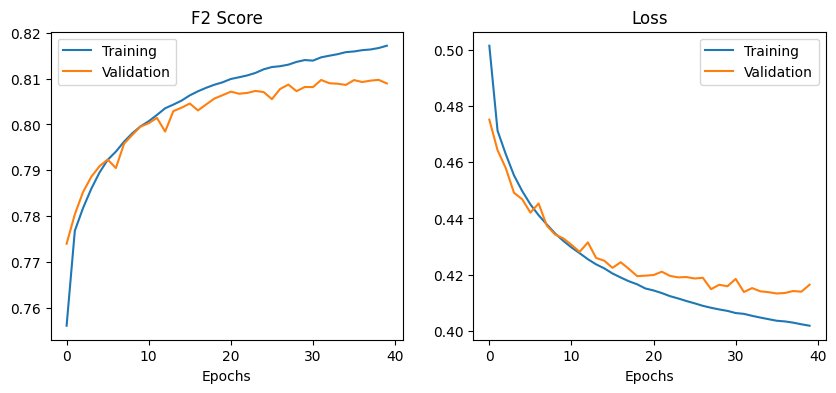

10000/10000 [==============================] - 12s 1ms/step


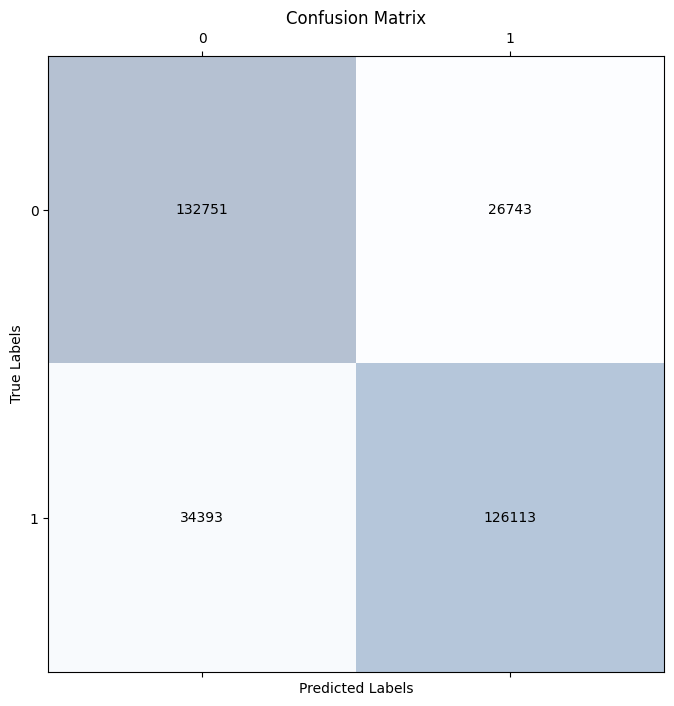

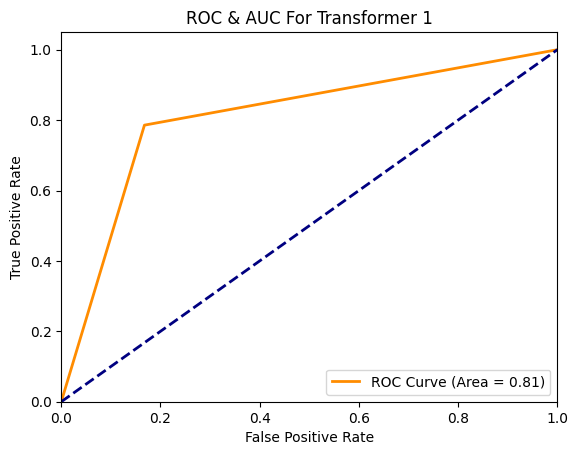

Validation Scores:
	F1 Score: 0.6680707931518555
	Recall: 0.7857214212417603
	Precision: 0.8250445127487183
	Accuracy: 0.8089500069618225


In [54]:
# Combine All Histories Together
combined = dict()
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'val_precision_9', 'val_recall_9', 'val_f1_score']:
    combined[key] = np.hstack([x.history[key] for x in history_xformer_1])

# Plot Training, Val Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(combined['accuracy'], label = 'Training')
plt.plot(combined['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('F2 Score')
plt.legend()

# Plot Training, Val Loss
plt.subplot(1, 2, 2)
plt.plot(combined['loss'], label = 'Training')
plt.plot(combined['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After Training, Predict Classes
y_pred = model_xformer_1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC, Calculate AUC
plot_roc_curve(y_test, y_pred_classes, 'Transformer 1')
print(f"Validation Scores:\n\tF1 Score: {combined['val_f1_score'][-1][-1]}\n\tRecall: {combined['val_recall_9'][-1]}")
print(f"\tPrecision: {combined['val_precision_9'][-1]}\n\tAccuracy: {combined['val_accuracy'][-1]}")

Probably could train for a little longer but already wow! Its way better! Do you know what we need??? MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN MORE ATTN 

## **3.2: MORE Attention Is All You Need Dumbass**

In [57]:
# No. Attention Heads (Double!)
num_heads = 8

# Hidden Layer Size FFN (Double!)
ff_dim = 64

# Define Model
inputs = Input(shape = (MAX_ART_LEN,))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.4)(x)

# Output Layer For Binary Classification
preds = Dense(1, activation = 'sigmoid')(x)

# Print Model
model_xformer_2 = Model(inputs = inputs, outputs = preds)
print(model_xformer_2.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180)]             0         
                                                                 
 glove_token_and_position_e  (None, 180, 100)          36127100  
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 180, 100)          335864    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_4  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 100)               0  

In [60]:
# Compile Transformer Architecture
model_xformer_2.compile(loss = 'binary_crossentropy', 
                        optimizer = 'adam',
                        metrics = ['accuracy', Precision(), Recall(), F1Score()])
history_xformer_2 = []
tmp = model_xformer_2.fit(X_train, y_train, 
                          validation_data = (X_test, y_test),
                          epochs = 10, batch_size = 512)
history_xformer_2.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 120s 47ms/step - loss: 0.4946 - accuracy: 0.7602 - precision_11: 0.7664 - recall_11: 0.7481 - f1_score: 0.6663 - val_loss: 0.4623 - val_accuracy: 0.7780 - val_precision_11: 0.8072 - val_recall_11: 0.7323 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4592 - accuracy: 0.7844 - precision_11: 0.7905 - recall_11: 0.7736 - f1_score: 0.6663 - val_loss: 0.4541 - val_accuracy: 0.7851 - val_precision_11: 0.7739 - val_recall_11: 0.8074 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4504 - accuracy: 0.7894 - precision_11: 0.7953 - recall_11: 0.7790 - f1_score: 0.6663 - val_loss: 0.4441 - val_accuracy: 0.7912 - val_precision_11: 0.7952 - val_recall_11: 0.7860 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4447 - accuracy: 0.7926 - precision_11: 0.7982 - recall_11: 0.7829 - f

In [61]:
tmp = model_xformer_2.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_2.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4216 - accuracy: 0.8058 - precision_11: 0.8113 - recall_11: 0.7967 - f1_score: 0.6663 - val_loss: 0.4273 - val_accuracy: 0.8011 - val_precision_11: 0.7871 - val_recall_11: 0.8273 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4197 - accuracy: 0.8069 - precision_11: 0.8121 - recall_11: 0.7981 - f1_score: 0.6663 - val_loss: 0.4244 - val_accuracy: 0.8032 - val_precision_11: 0.8095 - val_recall_11: 0.7947 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 118s 47ms/step - loss: 0.4176 - accuracy: 0.8079 - precision_11: 0.8132 - recall_11: 0.7989 - f1_score: 0.6663 - val_loss: 0.4240 - val_accuracy: 0.8048 - val_precision_11: 0.8105 - val_recall_11: 0.7974 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4156 - accuracy: 0.8093 - precision_11: 0.8142 - recall_11: 0.8010 - f

In [64]:
tmp = model_xformer_2.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_2.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4027 - accuracy: 0.8159 - precision_11: 0.8197 - recall_11: 0.8097 - f1_score: 0.6663 - val_loss: 0.4129 - val_accuracy: 0.8105 - val_precision_11: 0.8097 - val_recall_11: 0.8132 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4017 - accuracy: 0.8167 - precision_11: 0.8201 - recall_11: 0.8110 - f1_score: 0.6663 - val_loss: 0.4124 - val_accuracy: 0.8107 - val_precision_11: 0.8094 - val_recall_11: 0.8145 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4002 - accuracy: 0.8177 - precision_11: 0.8213 - recall_11: 0.8118 - f1_score: 0.6663 - val_loss: 0.4110 - val_accuracy: 0.8107 - val_precision_11: 0.8084 - val_recall_11: 0.8158 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.3989 - accuracy: 0.8184 - precision_11: 0.8219 - recall_11: 0.8124 - f

In [82]:
tmp = model_xformer_2.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_2.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 118s 47ms/step - loss: 0.3919 - accuracy: 0.8222 - precision_11: 0.8255 - recall_11: 0.8167 - f1_score: 0.6663 - val_loss: 0.4098 - val_accuracy: 0.8116 - val_precision_11: 0.8039 - val_recall_11: 0.8257 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 118s 47ms/step - loss: 0.3911 - accuracy: 0.8228 - precision_11: 0.8264 - recall_11: 0.8168 - f1_score: 0.6663 - val_loss: 0.4101 - val_accuracy: 0.8119 - val_precision_11: 0.8096 - val_recall_11: 0.8172 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 117s 47ms/step - loss: 0.3904 - accuracy: 0.8227 - precision_11: 0.8266 - recall_11: 0.8164 - f1_score: 0.6663 - val_loss: 0.4115 - val_accuracy: 0.8120 - val_precision_11: 0.8307 - val_recall_11: 0.7853 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 118s 47ms/step - loss: 0.3895 - accuracy: 0.8238 - precision_11: 0.8278 - recall_11: 0.8174 - f

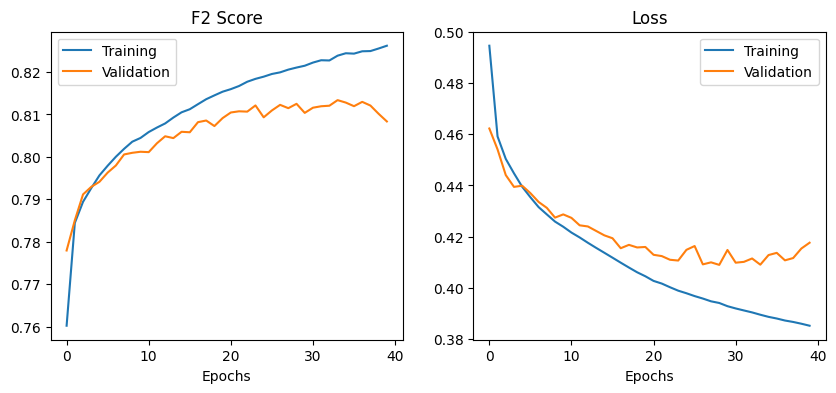

10000/10000 [==============================] - 16s 2ms/step


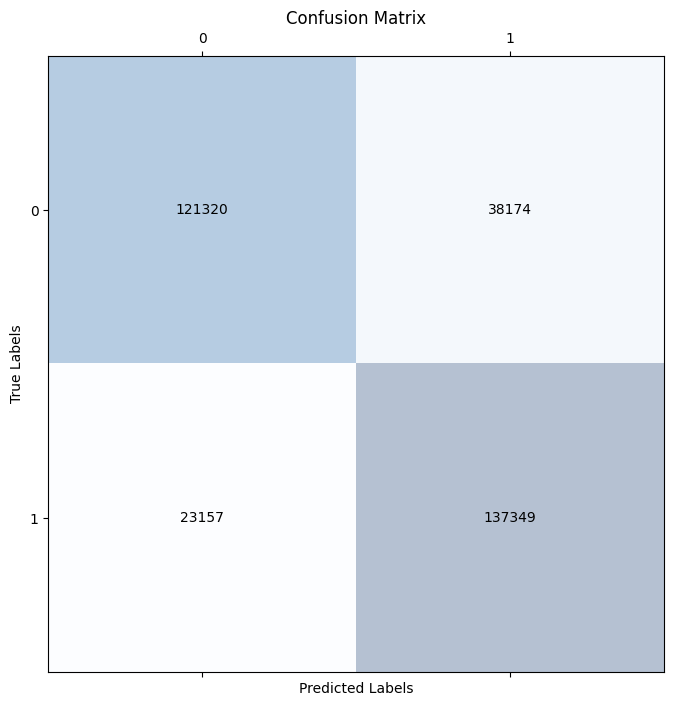

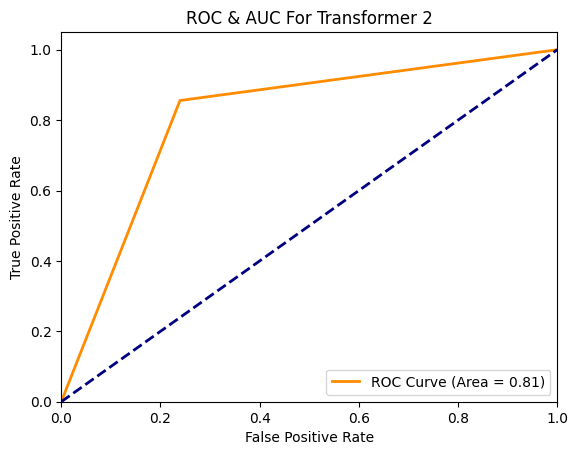

Validation Scores:
	F1 Score: 0.6680707931518555
	Recall: 0.8557249903678894
	Precision: 0.7825128436088562
	Accuracy: 0.8083406090736389


In [83]:
# Combine All Histories Together
combined = dict()
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'val_precision_11', 'val_recall_11', 'val_f1_score']:
    combined[key] = np.hstack([x.history[key] for x in history_xformer_2])

# Plot Training, Val Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(combined['accuracy'], label = 'Training')
plt.plot(combined['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('F2 Score')
plt.legend()

# Plot Training, Val Loss
plt.subplot(1, 2, 2)
plt.plot(combined['loss'], label = 'Training')
plt.plot(combined['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After Training, Predict Classes
y_pred = model_xformer_2.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC, Calculate AUC
plot_roc_curve(y_test, y_pred_classes, 'Transformer 2')
print(f"Validation Scores:\n\tF1 Score: {combined['val_f1_score'][-1][-1]}\n\tRecall: {combined['val_recall_11'][-1]}")
print(f"\tPrecision: {combined['val_precision_11'][-1]}\n\tAccuracy: {combined['val_accuracy'][-1]}")

This is converged enough for me fight me Larson

## **3.3: MORE MORE (x2) Attention Is All You Need Dumbass**

So the second transformer did slightly better so I gotta use that one :sob:

Since I'm running this one overnight and unconcious Trevor doesn't care about how long it takes to train let's do this shit for 80 epochs. I'm crazy

In [68]:
# No. Attention Heads (Double!)
num_heads = 8

# Hidden Layer Size FFN (Double!)
ff_dim = 64

# Define Model (Double!)
inputs = Input(shape = (MAX_ART_LEN,))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.4)(x)

# Output Layer For Binary Classification
preds = Dense(1, activation = 'sigmoid')(x)

# Print Model
model_xformer_3 = Model(inputs = inputs, outputs = preds)
print(model_xformer_3.summary())

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180)]             0         
                                                                 
 glove_token_and_position_e  (None, 180, 100)          36127100  
 mbedding_4 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_5 (Trans  (None, 180, 100)          335864    
 formerBlock)                                                    
                                                                 
 transformer_block_6 (Trans  (None, 180, 100)          335864    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_6  (None, 100)               0  

In [69]:
# Compile Transformer Architecture
model_xformer_3.compile(loss = 'binary_crossentropy', 
                        optimizer = opt,
                        metrics = ['accuracy', Precision(), Recall(), F1Score()])
history_xformer_3 = []
tmp = model_xformer_3.fit(X_train, y_train, 
                          validation_data = (X_test, y_test),
                          epochs = 10, batch_size = 512)
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 232s 92ms/step - loss: 0.5778 - accuracy: 0.6956 - precision_13: 0.7009 - recall_13: 0.6816 - f1_score: 0.6663 - val_loss: 0.5669 - val_accuracy: 0.7103 - val_precision_13: 0.7221 - val_recall_13: 0.6869 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.5445 - accuracy: 0.7227 - precision_13: 0.7294 - recall_13: 0.7073 - f1_score: 0.6663 - val_loss: 0.5428 - val_accuracy: 0.7301 - val_precision_13: 0.7872 - val_recall_13: 0.6329 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.5165 - accuracy: 0.7450 - precision_13: 0.7528 - recall_13: 0.7290 - f1_score: 0.6663 - val_loss: 0.5028 - val_accuracy: 0.7550 - val_precision_13: 0.7693 - val_recall_13: 0.7306 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.5015 - accuracy: 0.7558 - precision_13: 0.7623 - recall_13: 0.7429 - f

In [70]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4565 - accuracy: 0.7852 - precision_13: 0.7893 - recall_13: 0.7777 - f1_score: 0.6663 - val_loss: 0.4537 - val_accuracy: 0.7862 - val_precision_13: 0.7849 - val_recall_13: 0.7904 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4534 - accuracy: 0.7868 - precision_13: 0.7909 - recall_13: 0.7793 - f1_score: 0.6663 - val_loss: 0.4529 - val_accuracy: 0.7880 - val_precision_13: 0.7944 - val_recall_13: 0.7790 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4506 - accuracy: 0.7885 - precision_13: 0.7926 - recall_13: 0.7810 - f1_score: 0.6663 - val_loss: 0.4558 - val_accuracy: 0.7887 - val_precision_13: 0.7916 - val_recall_13: 0.7855 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4480 - accuracy: 0.7903 - precision_13: 0.7938 - recall_13: 0.7839 - f

In [71]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4348 - accuracy: 0.7977 - precision_13: 0.8007 - recall_13: 0.7923 - f1_score: 0.6663 - val_loss: 0.4464 - val_accuracy: 0.7951 - val_precision_13: 0.7915 - val_recall_13: 0.8030 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4336 - accuracy: 0.7986 - precision_13: 0.8016 - recall_13: 0.7931 - f1_score: 0.6663 - val_loss: 0.4479 - val_accuracy: 0.7931 - val_precision_13: 0.8196 - val_recall_13: 0.7535 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4320 - accuracy: 0.7992 - precision_13: 0.8028 - recall_13: 0.7929 - f1_score: 0.6663 - val_loss: 0.4445 - val_accuracy: 0.7967 - val_precision_13: 0.8027 - val_recall_13: 0.7884 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4308 - accuracy: 0.8000 - precision_13: 0.8031 - recall_13: 0.7944 - f

In [72]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4228 - accuracy: 0.8045 - precision_13: 0.8076 - recall_13: 0.7992 - f1_score: 0.6663 - val_loss: 0.4384 - val_accuracy: 0.7985 - val_precision_13: 0.7875 - val_recall_13: 0.8195 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4219 - accuracy: 0.8050 - precision_13: 0.8078 - recall_13: 0.8002 - f1_score: 0.6663 - val_loss: 0.4369 - val_accuracy: 0.8002 - val_precision_13: 0.7989 - val_recall_13: 0.8042 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4208 - accuracy: 0.8059 - precision_13: 0.8090 - recall_13: 0.8006 - f1_score: 0.6663 - val_loss: 0.4374 - val_accuracy: 0.8004 - val_precision_13: 0.8031 - val_recall_13: 0.7976 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4200 - accuracy: 0.8062 - precision_13: 0.8091 - recall_13: 0.8011 - f

In [73]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4139 - accuracy: 0.8095 - precision_13: 0.8121 - recall_13: 0.8049 - f1_score: 0.6663 - val_loss: 0.4387 - val_accuracy: 0.8007 - val_precision_13: 0.8128 - val_recall_13: 0.7831 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4131 - accuracy: 0.8099 - precision_13: 0.8129 - recall_13: 0.8046 - f1_score: 0.6663 - val_loss: 0.4348 - val_accuracy: 0.8006 - val_precision_13: 0.8057 - val_recall_13: 0.7940 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4124 - accuracy: 0.8103 - precision_13: 0.8135 - recall_13: 0.8049 - f1_score: 0.6663 - val_loss: 0.4375 - val_accuracy: 0.7992 - val_precision_13: 0.8234 - val_recall_13: 0.7635 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4118 - accuracy: 0.8107 - precision_13: 0.8139 - recall_13: 0.8053 - f

In [74]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4072 - accuracy: 0.8130 - precision_13: 0.8163 - recall_13: 0.8075 - f1_score: 0.6663 - val_loss: 0.4370 - val_accuracy: 0.8020 - val_precision_13: 0.8138 - val_recall_13: 0.7848 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4068 - accuracy: 0.8136 - precision_13: 0.8165 - recall_13: 0.8086 - f1_score: 0.6663 - val_loss: 0.4363 - val_accuracy: 0.8025 - val_precision_13: 0.8188 - val_recall_13: 0.7785 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 231s 92ms/step - loss: 0.4061 - accuracy: 0.8136 - precision_13: 0.8175 - recall_13: 0.8071 - f1_score: 0.6663 - val_loss: 0.4381 - val_accuracy: 0.8014 - val_precision_13: 0.8183 - val_recall_13: 0.7765 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4057 - accuracy: 0.8141 - precision_13: 0.8173 - recall_13: 0.8085 - f

In [75]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 231s 92ms/step - loss: 0.4018 - accuracy: 0.8160 - precision_13: 0.8192 - recall_13: 0.8106 - f1_score: 0.6663 - val_loss: 0.4386 - val_accuracy: 0.8018 - val_precision_13: 0.7996 - val_recall_13: 0.8072 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4012 - accuracy: 0.8164 - precision_13: 0.8197 - recall_13: 0.8109 - f1_score: 0.6663 - val_loss: 0.4422 - val_accuracy: 0.8019 - val_precision_13: 0.8245 - val_recall_13: 0.7688 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 231s 92ms/step - loss: 0.4009 - accuracy: 0.8167 - precision_13: 0.8199 - recall_13: 0.8113 - f1_score: 0.6663 - val_loss: 0.4375 - val_accuracy: 0.8013 - val_precision_13: 0.8187 - val_recall_13: 0.7756 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.4002 - accuracy: 0.8169 - precision_13: 0.8202 - recall_13: 0.8113 - f

In [76]:
tmp = model_xformer_3.fit(X_train, y_train, epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test))
history_xformer_3.append(tmp)

Epoch 1/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.3971 - accuracy: 0.8188 - precision_13: 0.8223 - recall_13: 0.8130 - f1_score: 0.6663 - val_loss: 0.4382 - val_accuracy: 0.8014 - val_precision_13: 0.8115 - val_recall_13: 0.7867 - val_f1_score: 0.6681
Epoch 2/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.3965 - accuracy: 0.8191 - precision_13: 0.8219 - recall_13: 0.8143 - f1_score: 0.6663 - val_loss: 0.4401 - val_accuracy: 0.8016 - val_precision_13: 0.8210 - val_recall_13: 0.7728 - val_f1_score: 0.6681
Epoch 3/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.3962 - accuracy: 0.8191 - precision_13: 0.8219 - recall_13: 0.8143 - f1_score: 0.6663 - val_loss: 0.4360 - val_accuracy: 0.8021 - val_precision_13: 0.7988 - val_recall_13: 0.8095 - val_f1_score: 0.6681
Epoch 4/10
2500/2500 [==============================] - 230s 92ms/step - loss: 0.3959 - accuracy: 0.8193 - precision_13: 0.8221 - recall_13: 0.8146 - f

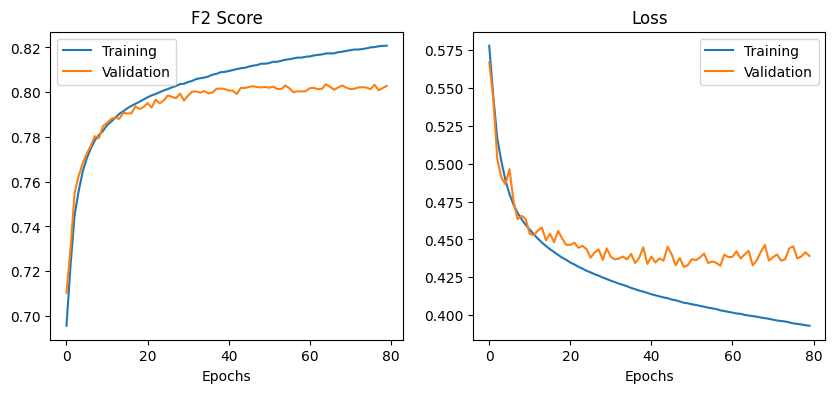

10000/10000 [==============================] - 27s 3ms/step


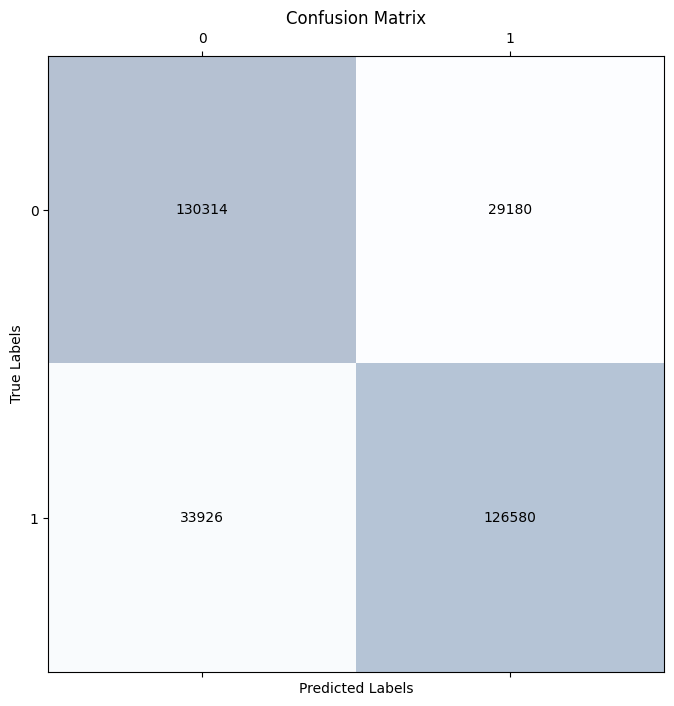

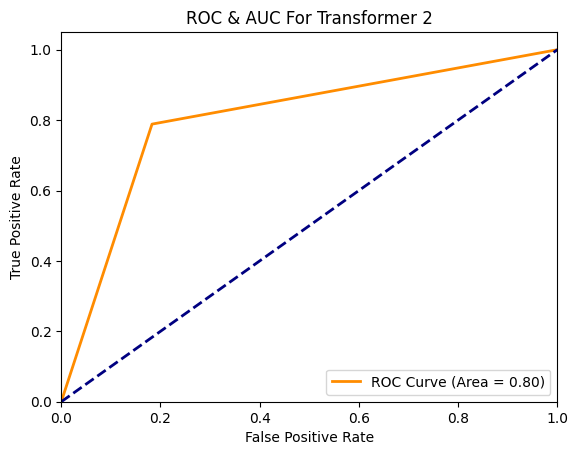

Validation Scores:
	F1 Score: 0.6680707931518555
	Recall: 0.7886309623718262
	Precision: 0.8126605153083801
	Accuracy: 0.8027937412261963


In [78]:
# Combine All Histories Together
combined = dict()
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'val_precision_13', 'val_recall_13', 'val_f1_score']:
    combined[key] = np.hstack([x.history[key] for x in history_xformer_3])

# Plot Training, Val Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(combined['accuracy'], label = 'Training')
plt.plot(combined['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('F2 Score')
plt.legend()

# Plot Training, Val Loss
plt.subplot(1, 2, 2)
plt.plot(combined['loss'], label = 'Training')
plt.plot(combined['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After Training, Predict Classes
y_pred = model_xformer_3.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC, Calculate AUC
plot_roc_curve(y_test, y_pred_classes, 'Transformer 2')
print(f"Validation Scores:\n\tF1 Score: {combined['val_f1_score'][-1][-1]}\n\tRecall: {combined['val_recall_13'][-1]}")
print(f"\tPrecision: {combined['val_precision_13'][-1]}\n\tAccuracy: {combined['val_accuracy'][-1]}")

This model trains way more stably, which is expected of a model with more attention layers and heads. And by trains more stably I mean that it takes longer to get started but its not gonna be weird in its convergence. It's very interpretable and makes sense. It converges to about the same accuracy as before. These factors are mainly due to the increased model complexity but feel free to ask GPT about this as well.

# **RNN (LSTM) Exceptional Credit**

Let's train an LSTM model or something I guess

In [ ]:
# Some Import Statements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Regular Stuff
model = Sequential()
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1, 
                    output_dim = EMBED_SIZE, 
                    weights = [embedding_matrix], 
                    input_length = MAX_ART_LEN, 
                    trainable = False))

# Bidirectional LSTM
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))

# Dense layers
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

# Compile As Usual, Let's Go 40 Epochs Like The Others
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy', Precision(), Recall(), F1Score()])
history_lstm = []
tmp = model.fit(X_train, y_train, 
                validation_data = (X_test, y_test),
                epochs = 40, batch_size = 512)
history_lstm.append(tmp)

In [ ]:
# Combine All Histories Together
combined = dict()
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'val_precision_12', 'val_recall_12', 'val_f1_score']:
    combined[key] = np.hstack([x.history[key] for x in history_lstm])

# Plot Training, Val Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(combined['accuracy'], label = 'Training')
plt.plot(combined['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('F2 Score')
plt.legend()

# Plot Training, Val Loss
plt.subplot(1, 2, 2)
plt.plot(combined['loss'], label = 'Training')
plt.plot(combined['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After Training, Predict Classes
y_pred = model_xformer_3.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC, Calculate AUC
plot_roc_curve(y_test, y_pred_classes, 'Transformer 2')
print(f"Validation Scores:\n\tF1 Score: {combined['val_f1_score'][-1][-1]}\n\tRecall: {combined['val_recall_12'][-1]}")
print(f"\tPrecision: {combined['val_precision_12'][-1]}\n\tAccuracy: {combined['val_accuracy'][-1]}")